# Exploratory analysis of options strategies

We are interested in the relation of volatility, as measured by the VIX, with different options strategies.  
VIX data provided by [CBOE](http://www.cboe.com/products/vix-index-volatility/vix-options-and-futures/vix-index/vix-historical-data)

In [1]:
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import warnings
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter("ignore")
register_matplotlib_converters()
sns.set()

In [2]:
# VIX data 1990-2003
vix_archive = pd.read_excel("../data/vixarchive.xls", skiprows=[0], parse_dates=["Date"], index_col="Date")
vix_archive.head()

,VIX Open,VIX High,VIX Low,VIX Close
Date,,,,
1990-01-02,NaN,NaN,NaN,17.24
1990-01-03,NaN,NaN,NaN,18.19
1990-01-04,NaN,NaN,NaN,19.22
1990-01-05,NaN,NaN,NaN,20.11
1990-01-08,NaN,NaN,NaN,20.26


In [3]:
len(vix_archive)

3532

In [4]:
# VIX data 2004-present
vix_current = pd.read_csv("../data/vixcurrent.csv", skiprows=1, parse_dates=["Date"], index_col="Date")
vix_current.head()

,VIX Open,VIX High,VIX Low,VIX Close
Date,,,,
2004-01-02,17.96,18.68,17.54,18.22
2004-01-05,18.45,18.49,17.44,17.49
2004-01-06,17.66,17.67,16.19,16.73
2004-01-07,16.72,16.75,15.50,15.50
2004-01-08,15.42,15.68,15.32,15.61


In [5]:
len(vix_current)

3825

In [6]:
vix_data = pd.concat([vix_archive, vix_current])
assert len(vix_data) == len(vix_archive) + len(vix_current)

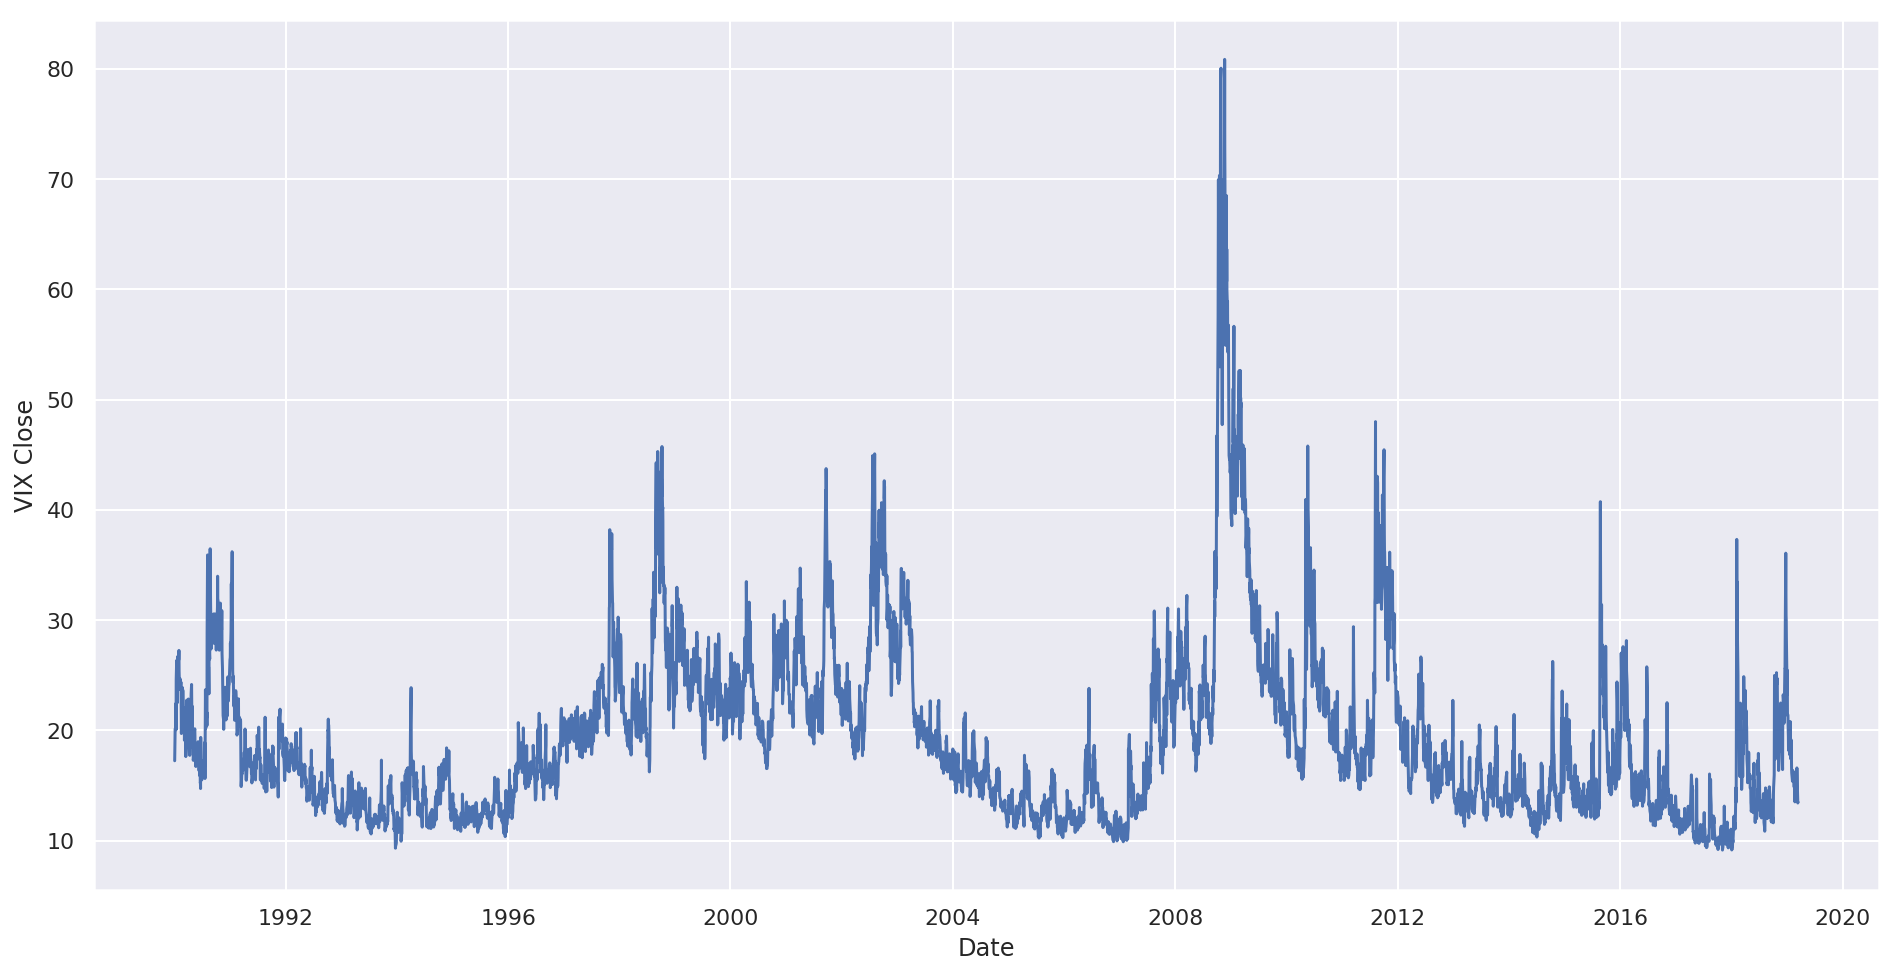

In [7]:
_fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=vix_data.index, y="VIX Close", data=vix_data, ax=ax)

In [4]:
spx_data = pd.read_csv("../data/allspx/SPX_2010.csv", parse_dates=["quotedate", "expiration"])
spx_data.head()

,underlying,underlying_last,exchange,optionroot,optionext,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias
0,SPX,1132.99,W,JXB100108C00925000,NaN,call,2010-01-08,2010-01-04,925,0.0,205.8,208.8,0,0,0.2284,0.9997,0.0,35.6003,0.0000,JXB100108C00925000
1,SPX,1132.99,W,JXB100108C00950000,NaN,call,2010-01-08,2010-01-04,950,0.0,180.9,183.9,0,0,0.2284,0.9997,0.0,35.5378,0.0000,JXB100108C00950000
2,SPX,1132.99,W,JXB100108C00975000,NaN,call,2010-01-08,2010-01-04,975,0.0,155.9,158.9,0,0,0.2284,0.9997,0.0,35.4753,0.0000,JXB100108C00975000
3,SPX,1132.99,W,JXB100108C01000000,NaN,call,2010-01-08,2010-01-04,1000,0.0,130.9,133.9,0,0,0.2284,0.9997,0.0,35.4127,0.0000,JXB100108C01000000
4,SPX,1132.99,W,JXB100108C01025000,NaN,call,2010-01-08,2010-01-04,1025,0.0,106.0,109.0,0,0,0.2284,0.9997,0.0,35.3356,0.0012,JXB100108C01025000


## Straddle

Parameters:
- `entry_dte`: Number of days to expiration to enter strategy
- `exit_dte`: Number of days to expiration to exit unconditionally
- `qty`: Position size (number of calls and puts to buy)

In [5]:
def dte_filter(data, dte):
    return data[data["expiration"] - data["quotedate"] == pd.Timedelta(days=dte)]

def exit_price(option, data):
    if option in data["optionroot"].array:
        return data[data["optionroot"] == option]["bid"].iloc[0]
    else:
        return 0.0

In [6]:
def straddle(data, entry_dte=36, exit_dte=2, qty=10):
    calls = data[data["type"] == "call"]
    call_candidates = dte_filter(calls, entry_dte)
    call_candidates["difference"] = np.abs(
        (call_candidates["strike"] - call_candidates["underlying_last"]))
    idx_calls = call_candidates.groupby(["quotedate"])["difference"].idxmin()
    straddle_call_enter = call_candidates.loc[idx_calls, ]
    call_exits = calls[calls["optionroot"].isin(
        straddle_call_enter["optionroot"])]
    straddle_call_exit = dte_filter(call_exits, exit_dte)

    puts = data[data["type"] == "put"]
    put_candidates = dte_filter(puts, entry_dte)
    put_candidates["difference"] = np.abs(
        (put_candidates["strike"] - put_candidates["underlying_last"]))
    idx_puts = put_candidates.groupby(["quotedate"])["difference"].idxmin()
    straddle_put_enter = put_candidates.loc[idx_puts, ]
    put_exits = puts[puts["optionroot"].isin(straddle_put_enter["optionroot"])]
    straddle_put_exit = dte_filter(put_exits, exit_dte)

    index = pd.Index(straddle_call_enter["quotedate"], name="date")
    results = pd.DataFrame(
        {
            "call": straddle_call_enter["optionroot"].array,
            "call_enter": straddle_call_enter["ask"].array * 100 * qty,
            "put": straddle_put_enter["optionroot"].array,
            "put_enter": straddle_put_enter["ask"].array * 100 * qty,
        },
        index=index)

    results.insert(2, "call_exit", results["call"].map(
        lambda option: exit_price(option, straddle_call_exit)) * 100 * qty)
    results["put_exit"] = results["put"].map(
        lambda option: exit_price(option, straddle_put_exit)) * 100 * qty
    results["profit"] = results["call_exit"] - results["call_enter"] + results[
        "put_exit"] - results["put_enter"]
    results["win/loss"] = results["profit"] >= 0.0
    results["win/loss"] = results["win/loss"].map({True: "win", False: "loss"}).astype("category")
    results["total"] = results["profit"].cumsum()

    return results

In [7]:
results = straddle(spx_data)

In [8]:
results

,call,call_enter,call_exit,put,put_enter,put_exit,profit,win/loss,total
date,,,,,,,,,
2010-01-15,SPT100220C01135000,21800.0,100.0,SPT100220P01135000,23100.0,28000.0,-16800.0,loss,-16800.0
2010-02-12,SPQ100320C01075000,30400.0,89000.0,SPQ100320P01075000,28100.0,0.0,30500.0,win,13700.0
2010-02-23,SPQ100331C01095000,22100.0,0.0,SPQ100331P01095000,20900.0,0.0,-43000.0,loss,-29300.0
2010-03-12,SPT100417C01150000,23200.0,60700.0,SPT100417P01150000,23500.0,150.0,14150.0,win,-15150.0
2010-03-25,SPQ100430C01095000,74700.0,0.0,SPQ100430P01095000,3300.0,0.0,-78000.0,loss,-93150.0
2010-04-16,SPT100522C01190000,24000.0,0.0,SPT100522P01190000,22500.0,0.0,-46500.0,loss,-139650.0
2010-05-14,SPT100619C01135000,37200.0,0.0,SPT100619P01135000,38100.0,0.0,-75300.0,loss,-214950.0
2010-06-11,SPX100717C01090000,34700.0,6500.0,SPX100717P01090000,35400.0,2450.0,-61150.0,loss,-276100.0
2010-07-16,SPX100821C01065000,32300.0,9800.0,SPX100821P01065000,33400.0,1150.0,-54750.0,loss,-330850.0


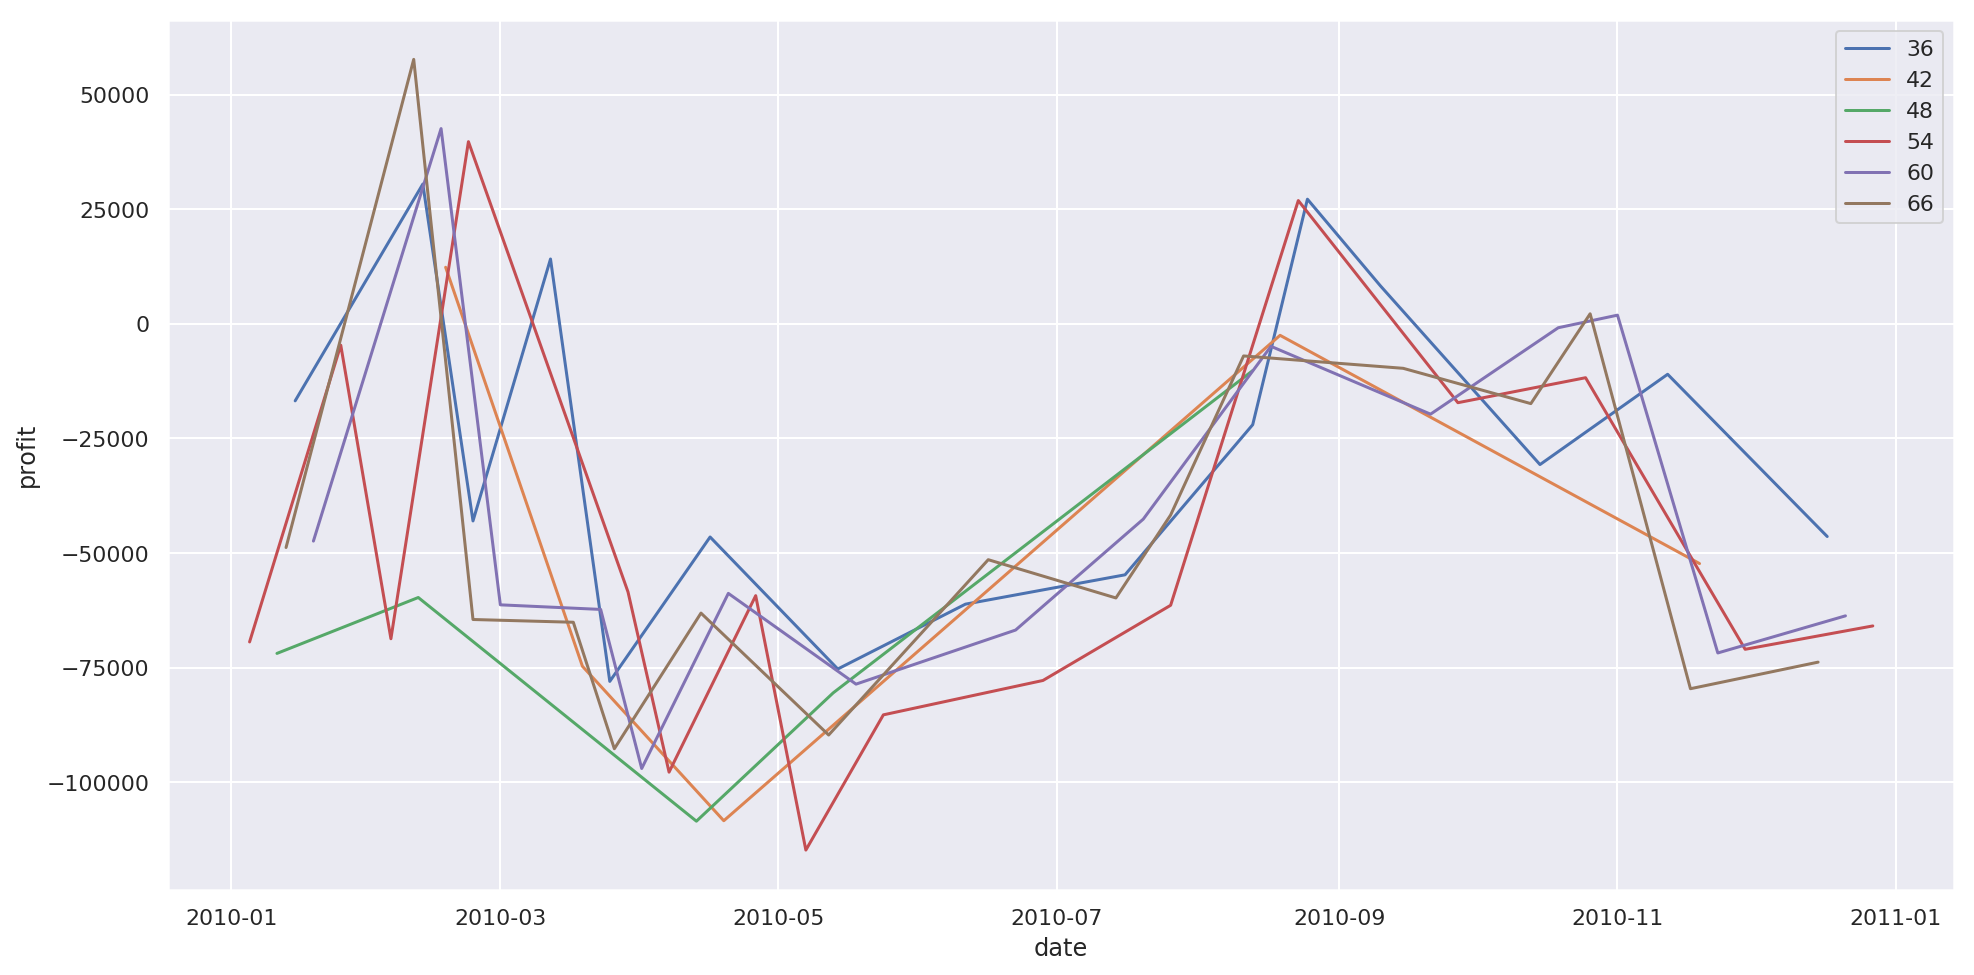

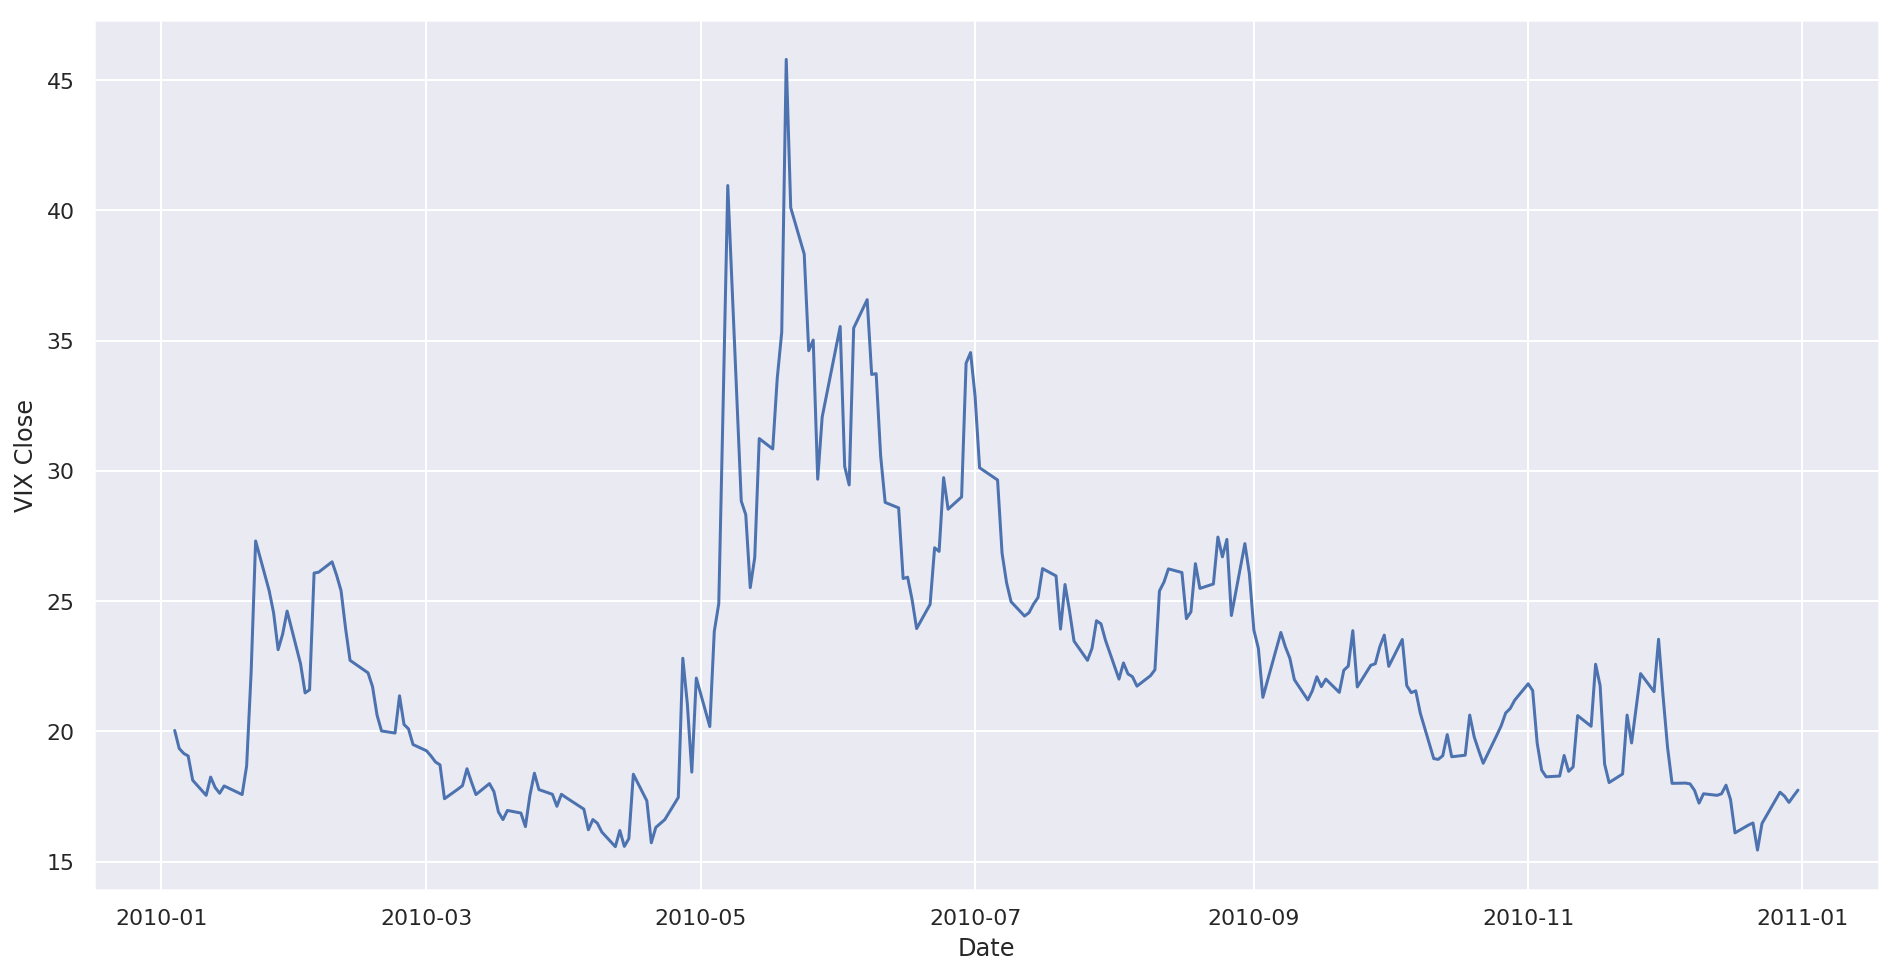

In [112]:
_fig, ax = plt.subplots(figsize=(16,8))
for entry_dte in range(36, 71, 6):
    results = straddle(spx_data, entry_dte=entry_dte)
    sns.lineplot(x=results.index, y="profit", data=results, ax=ax, label=entry_dte)
    
vix_2010 = vix_data.loc['2010',]
_fig, ax2 = plt.subplots(figsize=(16,8))
sns.lineplot(x=vix_2010.index, y="VIX Close", data=vix_2010)

## Straddle over all data

In [9]:
import gc

del results
gc.collect()

1016

In [11]:
all_data = pd.read_hdf("../data/options_data_v2.h5", key="/SPX")

In [12]:
results = straddle(all_data)

In [18]:
results.head(20)

,call,call_enter,call_exit,put,put_enter,put_exit,profit,win/loss,total
date,,,,,,,,,
1990-01-12,SPX900217C00340000,8800.0,100.0,SPX900217P00340000,9500.0,5000.0,-13200.0,loss,-13200.0
1990-02-09,SPX900317C00335000,8000.0,3500.0,SPX900317P00335000,8800.0,400.0,-12900.0,loss,-26100.0
1990-03-16,SPX900421C00340000,7600.0,400.0,SPX900421P00340000,4900.0,2800.0,-9300.0,loss,-35400.0
1990-05-11,SPX900616C00350000,9900.0,13000.0,SPX900616P00350000,5800.0,0.0,-2700.0,loss,-38100.0
1990-06-15,SPX900721C00365000,5800.0,1200.0,SPX900721P00365000,6400.0,900.0,-10100.0,loss,-48200.0
1990-07-13,SPX900818C00365000,9200.0,0.0,SPX900818P00365000,5900.0,34100.0,19000.0,win,-29200.0
1990-08-17,SPX900922C00330000,8800.0,0.0,SPX900922P00330000,10200.0,18200.0,-800.0,loss,-30000.0
1990-09-14,SPX901020C00315000,11400.0,100.0,SPX901020P00315000,9400.0,9100.0,-11600.0,loss,-41600.0
1990-10-12,SPX901117C00300000,11200.0,17100.0,SPX901117P00300000,10500.0,100.0,-4500.0,loss,-46100.0


In [14]:
results.tail()

,call,call_enter,call_exit,put,put_enter,put_exit,profit,win/loss,total
date,,,,,,,,,
2018-08-17,SPX180921C02850000,32600.0,80100.0,SPX180921P02850000,31400.0,100.0,16200.0,win,-8517450.0
2018-09-14,SPX181019C02905000,32500.0,0.0,SPX181019P02905000,28700.0,124800.0,63600.0,win,-8453850.0
2018-10-12,SPX181116C02765000,59900.0,500.0,SPX181116P02765000,58400.0,31000.0,-86800.0,loss,-8540650.0
2018-11-16,SPX181221C02735000,58000.0,0.0,SPX181221P02735000,52000.0,258400.0,148400.0,win,-8392250.0
2018-12-14,SPX190118C02600000,65100.0,0.0,SPX190118P02600000,60500.0,0.0,-125600.0,loss,-8517850.0


In [16]:
results["win/loss"].value_counts()

loss    450
win     192
Name: win/loss, dtype: int64

In [17]:
len(results)

642

In [20]:
all_data.head()

,underlying,underlying_last,exchange,optionroot,optionext,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias
0,SPX,359.69,*,SPX900120C00225000,NaN,call,1990-01-20,1990-01-02,225.0,0.0,135.5,135.5,0,820,0.0,0.0,0.0,0.0,0.0,SPX900120C00225000
1,SPX,359.69,*,SPX900120C00320000,NaN,call,1990-01-20,1990-01-02,320.0,0.0,40.9,40.9,0,1088,0.0,0.0,0.0,0.0,0.0,SPX900120C00320000
2,SPX,359.69,*,SPX900120C00325000,NaN,call,1990-01-20,1990-01-02,325.0,0.0,35.9,35.9,0,1252,0.0,0.0,0.0,0.0,0.0,SPX900120C00325000
3,SPX,359.69,*,SPX900120C00330000,NaN,call,1990-01-20,1990-01-02,330.0,30.5,30.9,30.9,25,8738,0.0,0.0,0.0,0.0,0.0,SPX900120C00330000
4,SPX,359.69,*,SPX900120C00335000,NaN,call,1990-01-20,1990-01-02,335.0,0.0,26.0,26.0,0,580,0.0,0.0,0.0,0.0,0.0,SPX900120C00335000


In [21]:
sliced = all_data.query("quotedate>='1995-01-01' & quotedate<='2003-12-31'")

In [22]:
sliced.head()

,underlying,underlying_last,exchange,optionroot,optionext,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias
300448,SPX,459.11,*,SPX950121C00375000,NaN,call,1995-01-21,1995-01-03,375.0,0.0,84.1,85.1,0,0,0.0886,1.0000,0.0000,-0.0648,0.0000,SPX950121C00375000
300449,SPX,459.11,*,SPX950121C00380000,NaN,call,1995-01-21,1995-01-03,380.0,0.0,79.3,80.3,0,0,0.0886,1.0000,0.0000,-0.0657,0.0000,SPX950121C00380000
300450,SPX,459.11,*,SPX950121C00400000,NaN,call,1995-01-21,1995-01-03,400.0,0.0,59.4,60.4,0,2,0.1436,1.0000,0.0000,-0.0691,0.0000,SPX950121C00400000
300451,SPX,459.11,*,SPX950121C00420000,NaN,call,1995-01-21,1995-01-03,420.0,0.0,40.0,41.0,0,319,0.2026,0.9824,0.0021,-0.0965,0.0434,SPX950121C00420000
300452,SPX,459.11,*,SPX950121C00425000,NaN,call,1995-01-21,1995-01-03,425.0,35.0,35.1,36.1,20,20,0.1817,0.9796,0.0027,-0.0976,0.0493,SPX950121C00425000


In [23]:
sliced.tail()

,underlying,underlying_last,exchange,optionroot,optionext,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias
1413752,SPX,1111.92,*,SXG051217P01250000,NaN,put,2005-12-17,2003-12-31,1250.0,0.0,165.5,168.5,0,0,0.1347,-0.6802,0.0016,-14.9229,537.1322,SXG051217P01250000
1413753,SPX,1111.92,*,SXG051217P01300000,NaN,put,2005-12-17,2003-12-31,1300.0,0.0,200.6,203.6,0,0,0.1313,-0.7548,0.0015,-11.4603,465.4420,SXG051217P01300000
1413754,SPX,1111.92,*,SXG051217P01325000,NaN,put,2005-12-17,2003-12-31,1325.0,0.0,219.3,222.3,0,0,0.1301,-0.7871,0.0013,-9.6928,425.6061,SXG051217P01325000
1413755,SPX,1111.92,*,SXG051217P01350000,NaN,put,2005-12-17,2003-12-31,1350.0,0.0,238.7,241.7,0,6,0.1292,-0.8158,0.0012,-7.9588,385.1799,SXG051217P01350000
1413756,SPX,1111.92,*,SXG051217P01400000,NaN,put,2005-12-17,2003-12-31,1400.0,0.0,0.0,0.0,0,8,0.1283,-0.8626,0.0010,-4.7362,307.9436,SXG051217P01400000


In [24]:
sliced_results = straddle(sliced)
sliced_results

,call,call_enter,call_exit,put,put_enter,put_exit,profit,win/loss,total
date,,,,,,,,,
1995-01-13,SPX950218C00465000,7100.0,20100.0,SPX950218P00465000,4200.0,0.0,8800.0,win,8.800000e+03
1995-02-10,SPX950318C00480000,7400.0,15100.0,SPX950318P00480000,4200.0,0.0,3500.0,win,1.230000e+04
1995-02-23,SPX950331C00490000,4200.0,13200.0,SPX950331P00490000,6100.0,0.0,2900.0,win,1.520000e+04
1995-03-17,SPX950422C00495000,7300.0,10100.0,SPX950422P00495000,5000.0,0.0,-2200.0,loss,1.300000e+04
1995-05-12,SPX950617C00525000,7400.0,12400.0,SPX950617P00525000,5300.0,0.0,-300.0,loss,1.270000e+04
1995-05-25,SPX950630C00530000,6100.0,0.0,SPX950630P00530000,7100.0,200.0,-13000.0,loss,-3.000000e+02
1995-06-16,SPX950722C00540000,7100.0,13100.0,SPX950722P00540000,5400.0,0.0,600.0,win,3.000000e+02
1995-07-14,SPX950819C00560000,8200.0,300.0,SPX950819P00560000,7200.0,1200.0,-13900.0,loss,-1.360000e+04
1995-08-11,SPX950916C00555000,8400.0,28400.0,SPX950916P00555000,6400.0,0.0,13600.0,win,5.456968e-12


In [25]:
sliced_results["win/loss"].value_counts()

loss    74
win     36
Name: win/loss, dtype: int64

In [26]:
results_66_dte = straddle(all_data, entry_dte=66)
results_66_dte

,call,call_enter,call_exit,put,put_enter,put_exit,profit,win/loss,total
date,,,,,,,,,
1990-01-10,SPX900317C00345000,14900.0,0.0,SPX900317P00345000,9000.0,7500.0,-1.640000e+04,loss,-16400.0
1990-04-11,SPX900616C00340000,14000.0,23000.0,SPX900616P00340000,8900.0,0.0,1.000000e+02,win,-16300.0
1990-07-18,SPX900922C00365000,10500.0,0.0,SPX900922P00365000,8600.0,53200.0,3.410000e+04,win,17800.0
1990-10-17,SPX901222C00300000,14400.0,29800.0,SPX901222P00300000,13600.0,0.0,1.800000e+03,win,19600.0
1991-01-09,SPX910316C00310000,16000.0,62600.0,SPX910316P00310000,13400.0,0.0,3.320000e+04,win,52800.0
1991-04-17,SPX910622C00390000,11100.0,0.0,SPX910622P00390000,9200.0,13800.0,-6.500000e+03,loss,46300.0
1991-07-17,SPX910921C00380000,12200.0,7100.0,SPX910921P00380000,9000.0,0.0,-1.410000e+04,loss,32200.0
1991-10-16,SPX911221C00395000,9400.0,0.0,SPX911221P00395000,10100.0,11400.0,-8.100000e+03,loss,24100.0
1992-01-15,SPX920321C00420000,12000.0,0.0,SPX920321P00420000,10300.0,9400.0,-1.290000e+04,loss,11200.0


In [27]:
results_66_dte["win/loss"].value_counts()

loss    322
win     130
Name: win/loss, dtype: int64

In [28]:
results_exit_30 = straddle(all_data, entry_dte=66, exit_dte=30)
results_exit_30

,call,call_enter,call_exit,put,put_enter,put_exit,profit,win/loss,total
date,,,,,,,,,
1990-01-10,SPX900317C00345000,14900.0,1900.0,SPX900317P00345000,9000.0,11000.0,-11000.0,loss,-11000.0
1990-04-11,SPX900616C00340000,14000.0,17400.0,SPX900616P00340000,8900.0,1500.0,-4000.0,loss,-15000.0
1990-07-18,SPX900922C00365000,10500.0,100.0,SPX900922P00365000,8600.0,58100.0,39100.0,win,24100.0
1990-10-17,SPX901222C00300000,14400.0,0.0,SPX901222P00300000,13600.0,0.0,-28000.0,loss,-3900.0
1991-01-09,SPX910316C00310000,16000.0,55000.0,SPX910316P00310000,13400.0,300.0,25900.0,win,22000.0
1991-04-17,SPX910622C00390000,11100.0,1100.0,SPX910622P00390000,9200.0,15000.0,-4200.0,loss,17800.0
1991-07-17,SPX910921C00380000,12200.0,14000.0,SPX910921P00380000,9000.0,1400.0,-5800.0,loss,12000.0
1991-10-16,SPX911221C00395000,9400.0,1200.0,SPX911221P00395000,10100.0,15200.0,-3100.0,loss,8900.0
1992-01-15,SPX920321C00420000,12000.0,3400.0,SPX920321P00420000,10300.0,9300.0,-9600.0,loss,-700.0


In [29]:
results_exit_30["win/loss"].value_counts()

loss    355
win      97
Name: win/loss, dtype: int64